### Formatting of post-processed in vivo read counts from smartseq


## QC

In [1]:
import scanpy as sc
import anndata as ad
import os
import datetime
import pandas as pd
seed=1
import matplotlib.pyplot as plt
# from pybiomart import Dataset
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

In [2]:
folder ="dt/in_vivo_dataset_counts"
adatas = {}

for file in os.listdir(folder):
    if file.endswith("_counts.txt"):  # Check if counts file
        path = os.path.join(folder, file)
        # Read adata
        sample_adata = sc.read_text(path).transpose()
        sample_adata.var_names_make_unique()
        cond = file.split("_")[0]
        sample_adata.obs['condition'] = cond
        
        adatas[cond] = sample_adata

In [3]:
adata = ad.concat(adatas, label="sample")
adata.obs_names_make_unique()
print(adata.obs["sample"].value_counts())
adata

SLX-11523    96
SLX-11519    96
SLX-11522    96
SLX-11521    96
SLX-11520    96
SLX-11517    88
Name: sample, dtype: int64


AnnData object with n_obs × n_vars = 568 × 32980
    obs: 'condition', 'sample'

In [4]:
metadt = pd.read_csv("dt/in_vivo_dataset_counts/Annotation.txt",sep = "\t")

In [5]:
metadt.index = metadt['Sample_id'].apply(lambda x: x.replace("SLX.","SLX-"))

In [6]:
metadt

,Sample_id,Plate,Animal,Batch,Condition,Well
Sample_id,,,,,,
SLX-11517.i702_i502,SLX.11517.i702_i502,1,A,1,Lesion,B2
SLX-11517.i702_i503,SLX.11517.i702_i503,1,A,1,Lesion,C2
SLX-11517.i702_i504,SLX.11517.i702_i504,1,A,1,Lesion,D2
SLX-11517.i702_i505,SLX.11517.i702_i505,1,A,1,Lesion,E2
SLX-11517.i702_i506,SLX.11517.i702_i506,1,A,1,Lesion,F2
...,...,...,...,...,...,...
SLX-11523.i712_i505,SLX.11523.i712_i505,6,F,3,Naive,E12
SLX-11523.i712_i506,SLX.11523.i712_i506,6,F,3,Naive,F12
SLX-11523.i712_i507,SLX.11523.i712_i507,6,F,3,Naive,G12


In [7]:
adata.obs = adata.obs.merge(how='left',right=metadt, left_index=True, right_index=True)

In [8]:
gene_names = pd.read_csv("dt/BMP4_SC_filtered_feature_bc_matrix/features copy.tsv",sep = "\t", names=['gene_symbol','gene_name','type'], header=None)

In [9]:
gene_names.index = gene_names['gene_symbol']

In [10]:
adata = adata[:, ~adata.var_names.isin(['__no_feature', '__ambiguous', '__too_low_aQual', '__not_aligned',
       '__alignment_not_unique'])]

In [11]:
adata.var = adata.var.merge(how='left',right=gene_names, left_index=True, right_index=True)

In [12]:
adata.var['gene_symbol_with_control'] = adata.var.index.values

In [13]:
adata.var['gene_name'].fillna(adata.var['gene_symbol_with_control'], inplace=True)

In [14]:
adata.write_h5ad("dt_out/0_preprocessing/invivo_raw_counts_combined_unprocessed.h5ad")

In [15]:
adata.var_names = adata.var['gene_name'].astype(str)

In [16]:
adata.var_names_make_unique()

In [17]:
adata.write_h5ad("dt_out/0_preprocessing/invivo_raw_counts_combined_fixed_varname.h5ad")

In [18]:
# adata = sc.read_h5ad("dt_out/0_preprocessing/invivo_raw_counts_combined_fixed_varname.h5ad")

In [19]:
adata.var_names_make_unique()

In [20]:
adata.var["mt"] = adata.var_names.str.startswith("Mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl"))
adata.var["ERCC"] = adata.var_names.str.startswith(("ERCC"))

In [21]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo","ERCC"], inplace=True, log1p=False
)

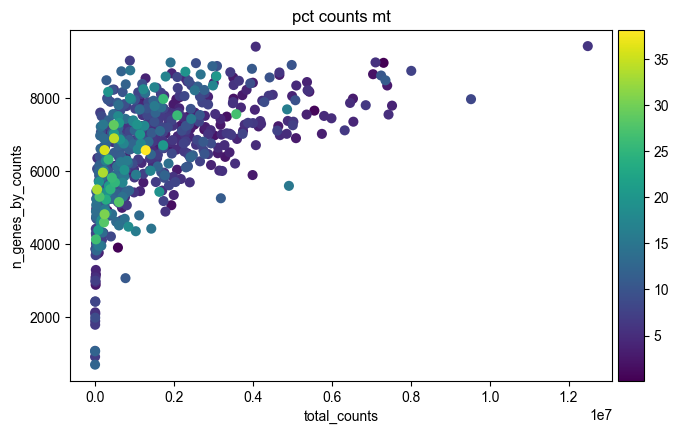

In [22]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [23]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [24]:
adata

AnnData object with n_obs × n_vars = 568 × 19459
    obs: 'condition', 'sample', 'Sample_id', 'Plate', 'Animal', 'Batch', 'Condition', 'Well', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_ERCC', 'pct_counts_ERCC', 'n_genes'
    var: 'gene_symbol', 'gene_name', 'type', 'gene_symbol_with_control', 'mt', 'ribo', 'ERCC', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:784: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:784: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:784: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:784: FutureWarning: 

The `scale` parameter has been renamed and will be 

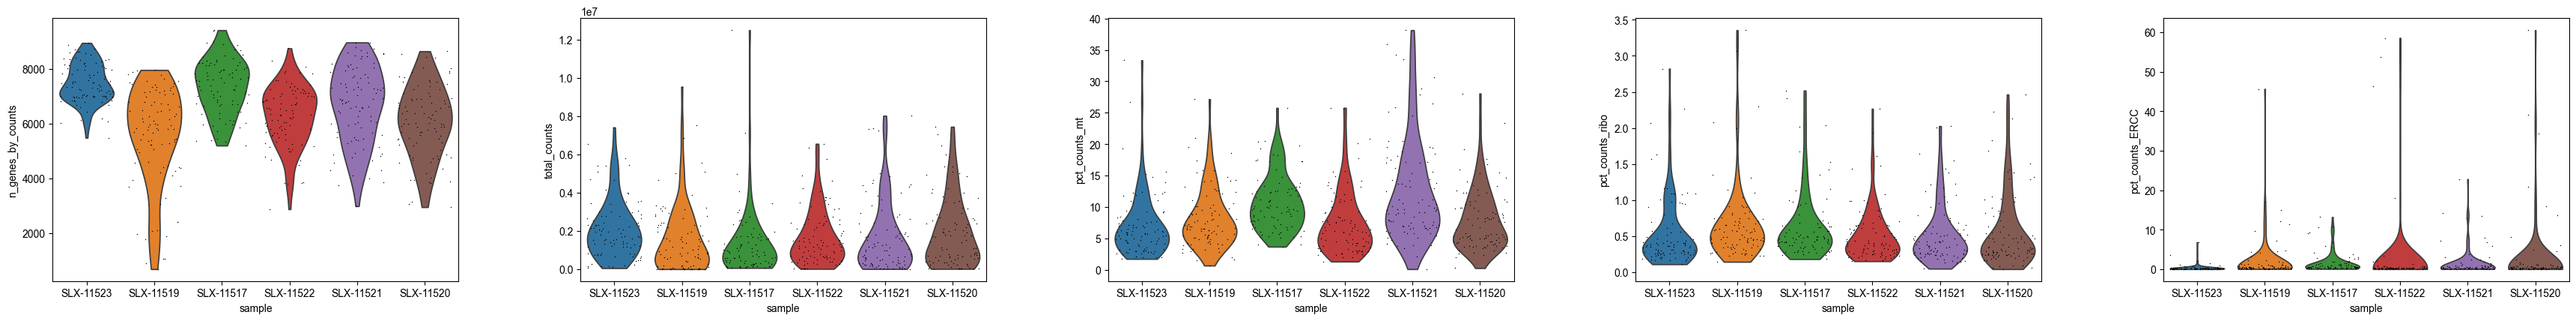

In [26]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo',"pct_counts_ERCC"],
             jitter=0.4, groupby = 'sample')

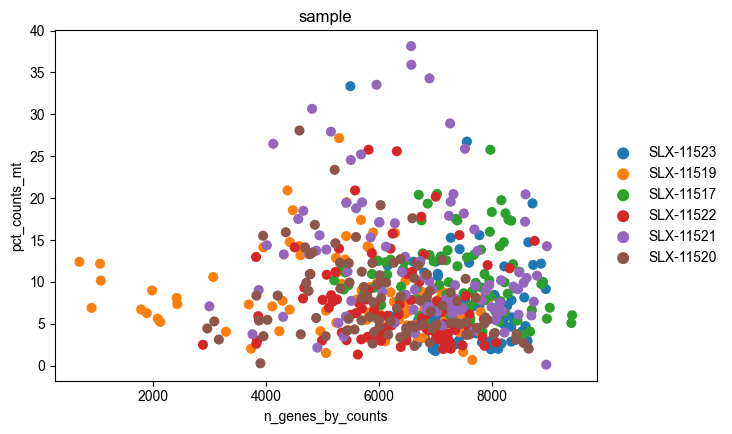

In [27]:
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt', color="sample")

In [28]:
adata.write_h5ad("dt_out/0_preprocessing/invivo_raw_counts_combined_fixed_varname_filtered_beforeQC.h5ad")

quick filter based on mt and total counts and genes

In [32]:
adata.obs["outlier_mt"] = adata.obs.pct_counts_mt > 22
adata.obs["outlier_total"] = adata.obs.total_counts > 0.7*1e7
adata.obs["outlier_ngenes"] = adata.obs.n_genes_by_counts < 3000
adata.obs["outlier_ERCC"] = adata.obs.pct_counts_ERCC > 20

print(
    "%u cells with high %% of mitochondrial genes"
    % (sum(adata.obs["outlier_mt"]))
)
print("%u cells with large total counts" % (sum(adata.obs["outlier_total"])))
print("%u cells with large number of genes" % (sum(adata.obs["outlier_ngenes"])))
print("%u cells with high pct_counts_ERCC" % (sum(adata.obs["outlier_ERCC"])))

adata = adata[~adata.obs["outlier_mt"], :]
adata = adata[~adata.obs["outlier_total"], :]
adata = adata[~adata.obs["outlier_ngenes"], :]
adata = adata[~adata.obs["outlier_ERCC"], :]

0 cells with high % of mitochondrial genes
0 cells with large total counts
0 cells with large number of genes
0 cells with high pct_counts_ERCC


/var/folders/lb/xhq_wzhs30l78s_s99z52_jh0000gq/T/ipykernel_33408/3247131583.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["outlier_mt"] = adata.obs.pct_counts_mt > 22


In [34]:
568 - 517

51

## Normalisation & HVG 

In [86]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [87]:
adata.obs['Batch'] = adata.obs['Batch'].astype(str)
adata.obs['Animal'] = adata.obs['Animal'].astype(str)

In [88]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000, batch_key="Animal")

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarnin

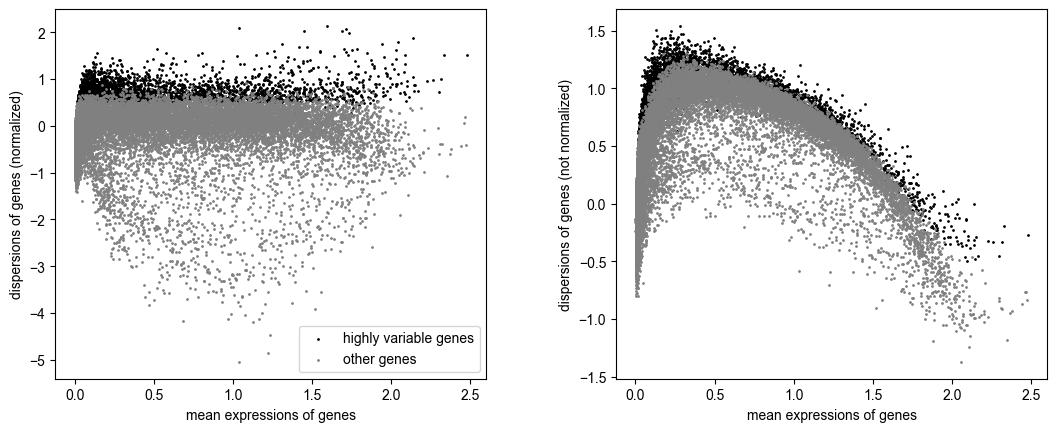

In [89]:
sc.pl.highly_variable_genes(adata)

In [ ]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

In [39]:
sc.tl.pca(adata)

In [40]:
adata

AnnData object with n_obs × n_vars = 517 × 19459
    obs: 'condition', 'sample', 'Sample_id', 'Plate', 'Animal', 'Batch', 'Condition', 'Well', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_ERCC', 'pct_counts_ERCC', 'n_genes', 'outlier_mt', 'outlier_total', 'outlier_ngenes', 'outlier_ERCC'
    var: 'gene_symbol', 'gene_name', 'type', 'gene_symbol_with_control', 'mt', 'ribo', 'ERCC', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'sample_colors', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


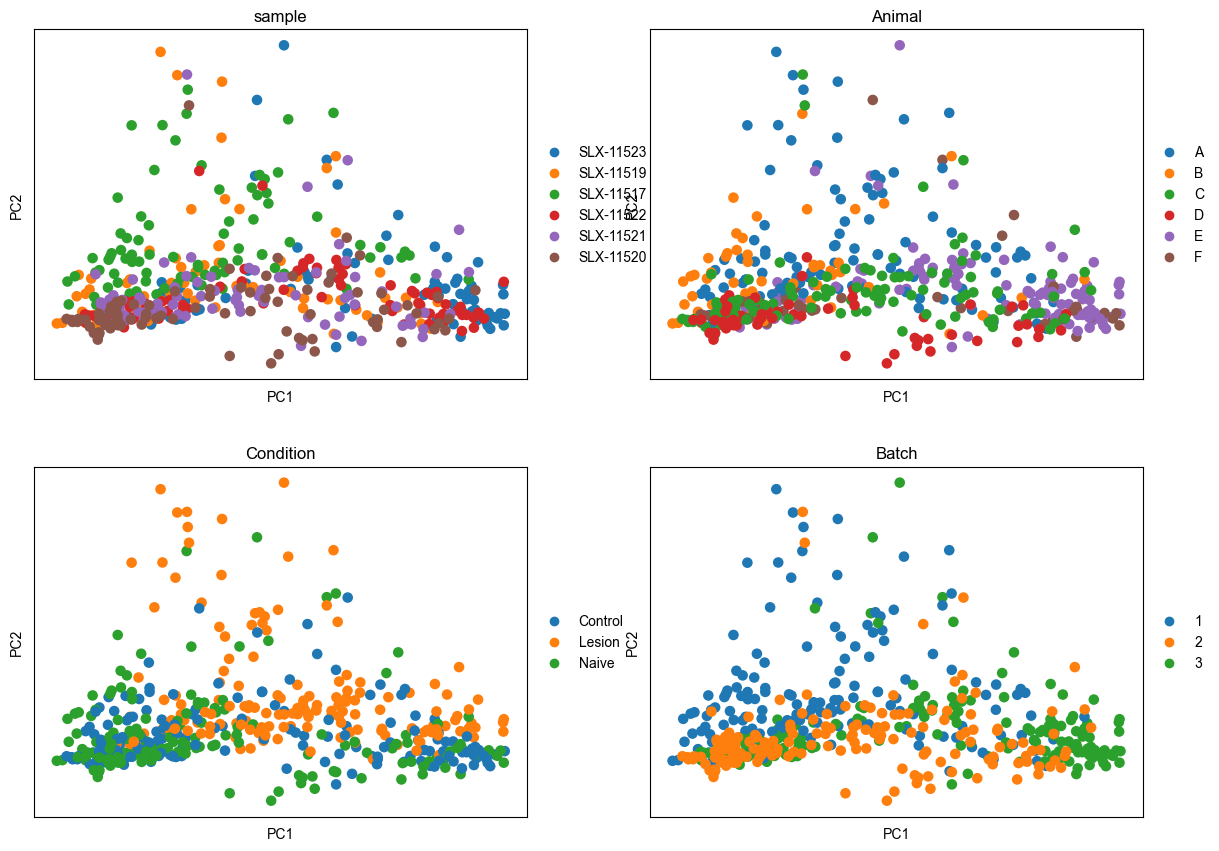

In [41]:
sc.pl.pca(
    adata,
    color=["sample", "Animal", "Condition", "Batch"],
    ncols=2,
)

In [42]:
sc.pp.neighbors(adata)

In [43]:
sc.tl.umap(adata,random_state=seed)

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


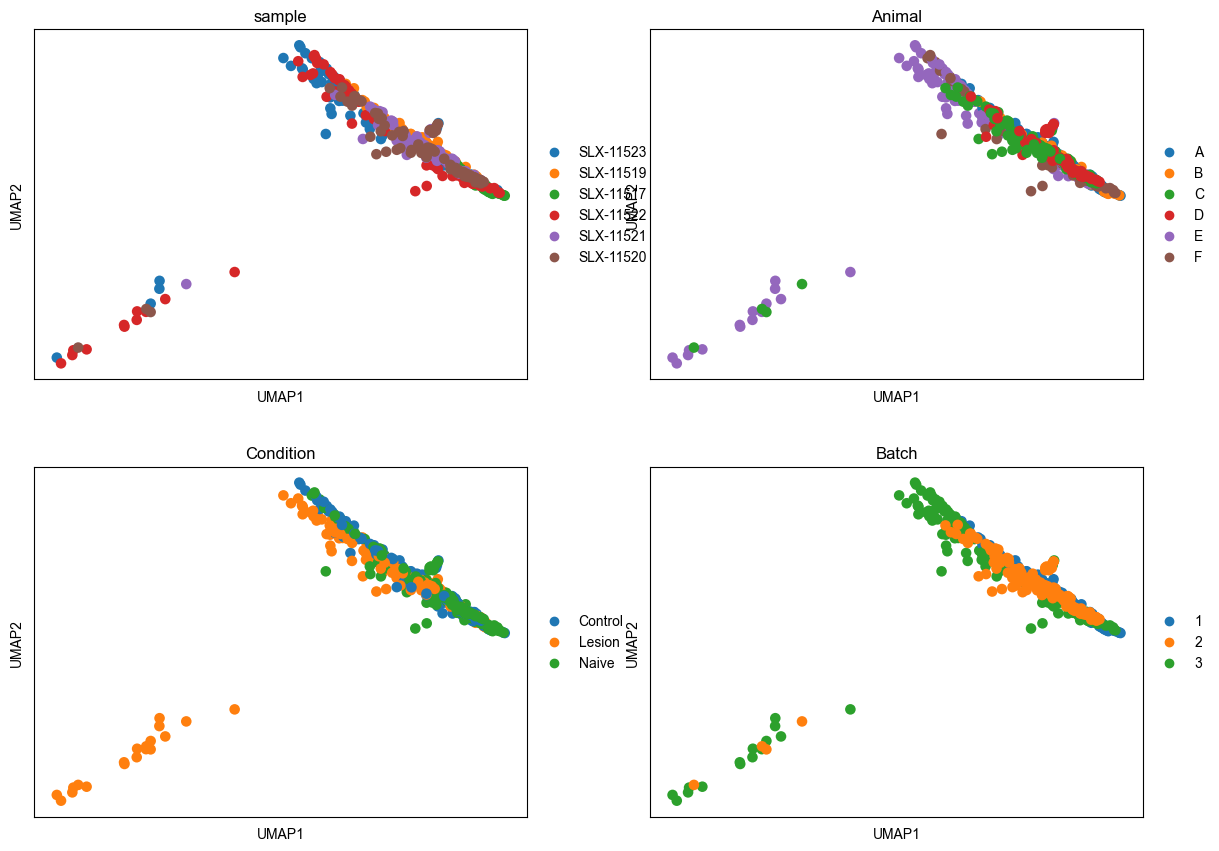

In [44]:
sc.pl.umap(
    adata,
    color=["sample", "Animal", "Condition", "Batch"],
    ncols=2,
)

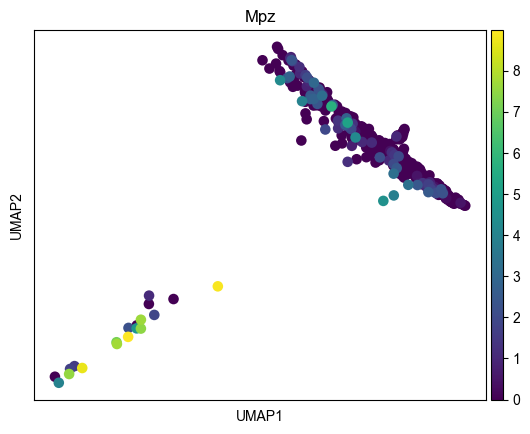

In [45]:
sc.pl.umap(
    adata,
    color=["Mpz"],
    ncols=2,
)

In [46]:
sc.tl.leiden(adata, n_iterations=2)

In [47]:
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_0.5',n_iterations=2)

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


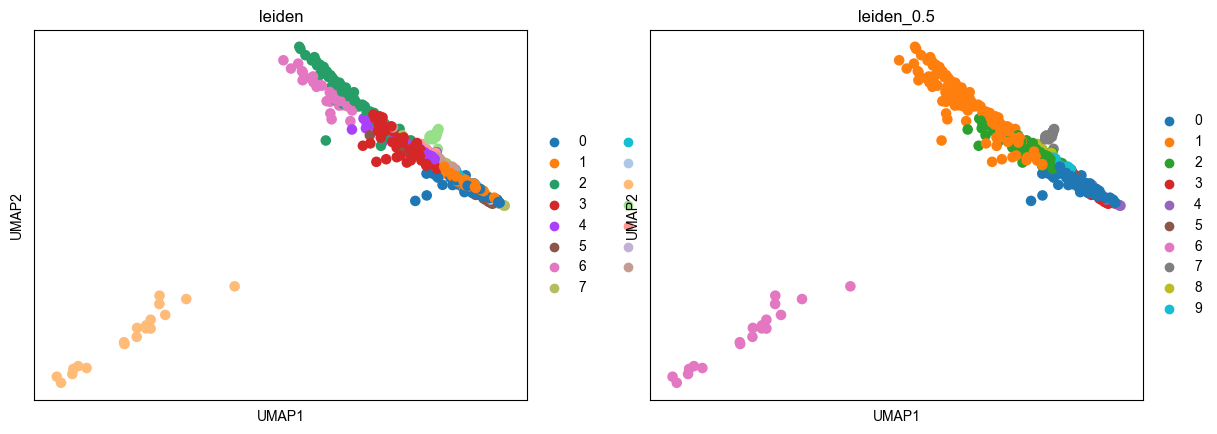

In [48]:
sc.pl.umap(adata, color=["leiden",'leiden_0.5'])

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


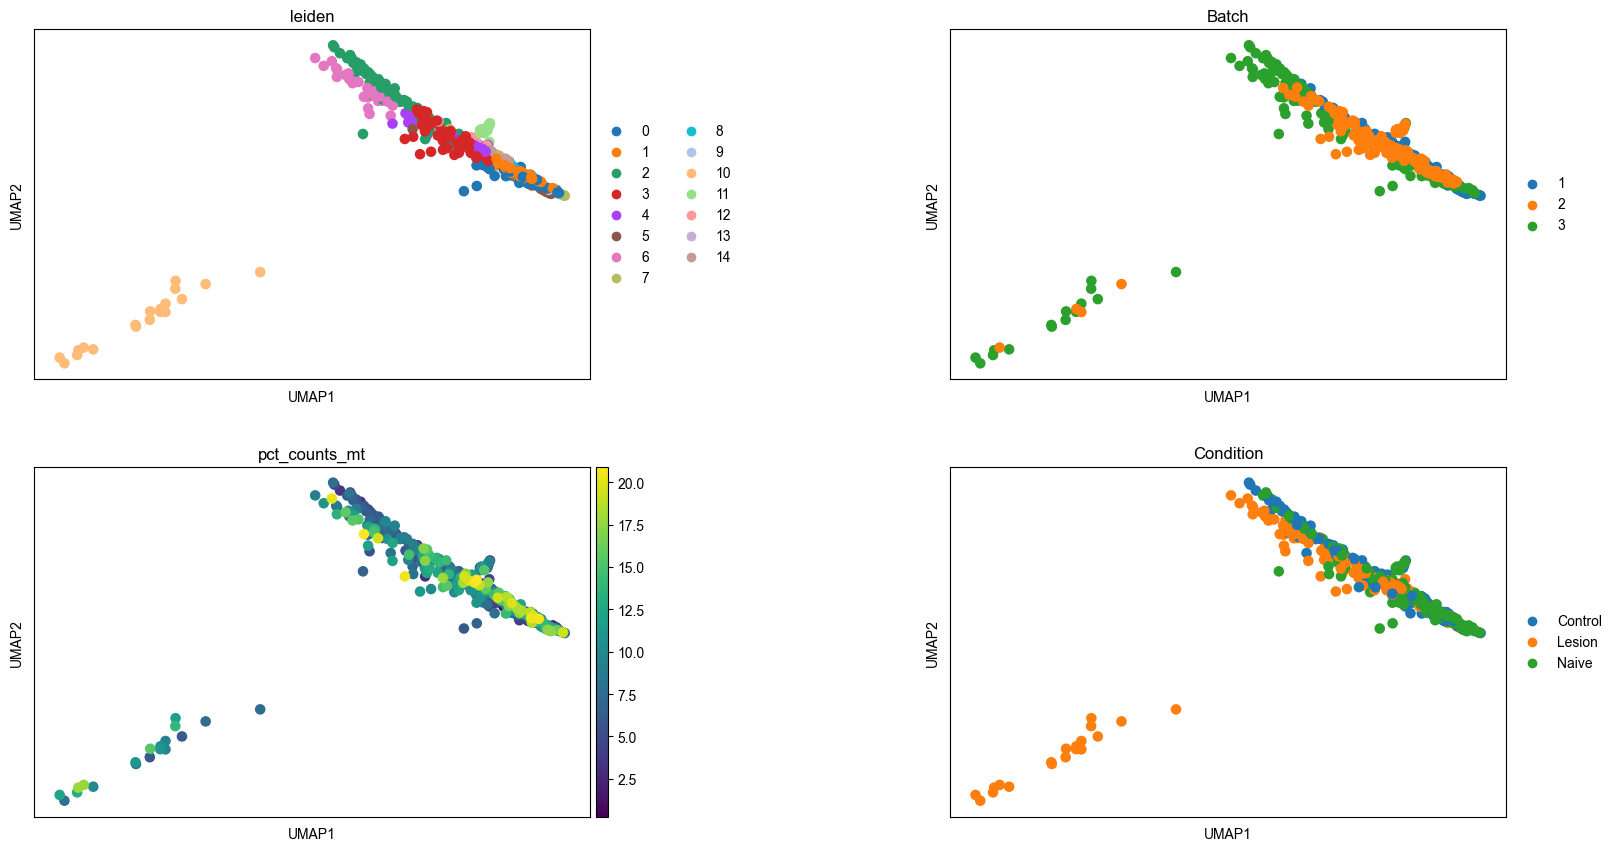

In [49]:
sc.pl.umap(
    adata,
    color=["leiden", "Batch", "pct_counts_mt", "Condition"],
    wspace=0.5,
    ncols=2,
)

In [50]:
adata.write_h5ad("dt_out/0_preprocessing/invivo_raw_counts_combined_fixed_varname_filtered_afterQC_umap_v2.h5ad")

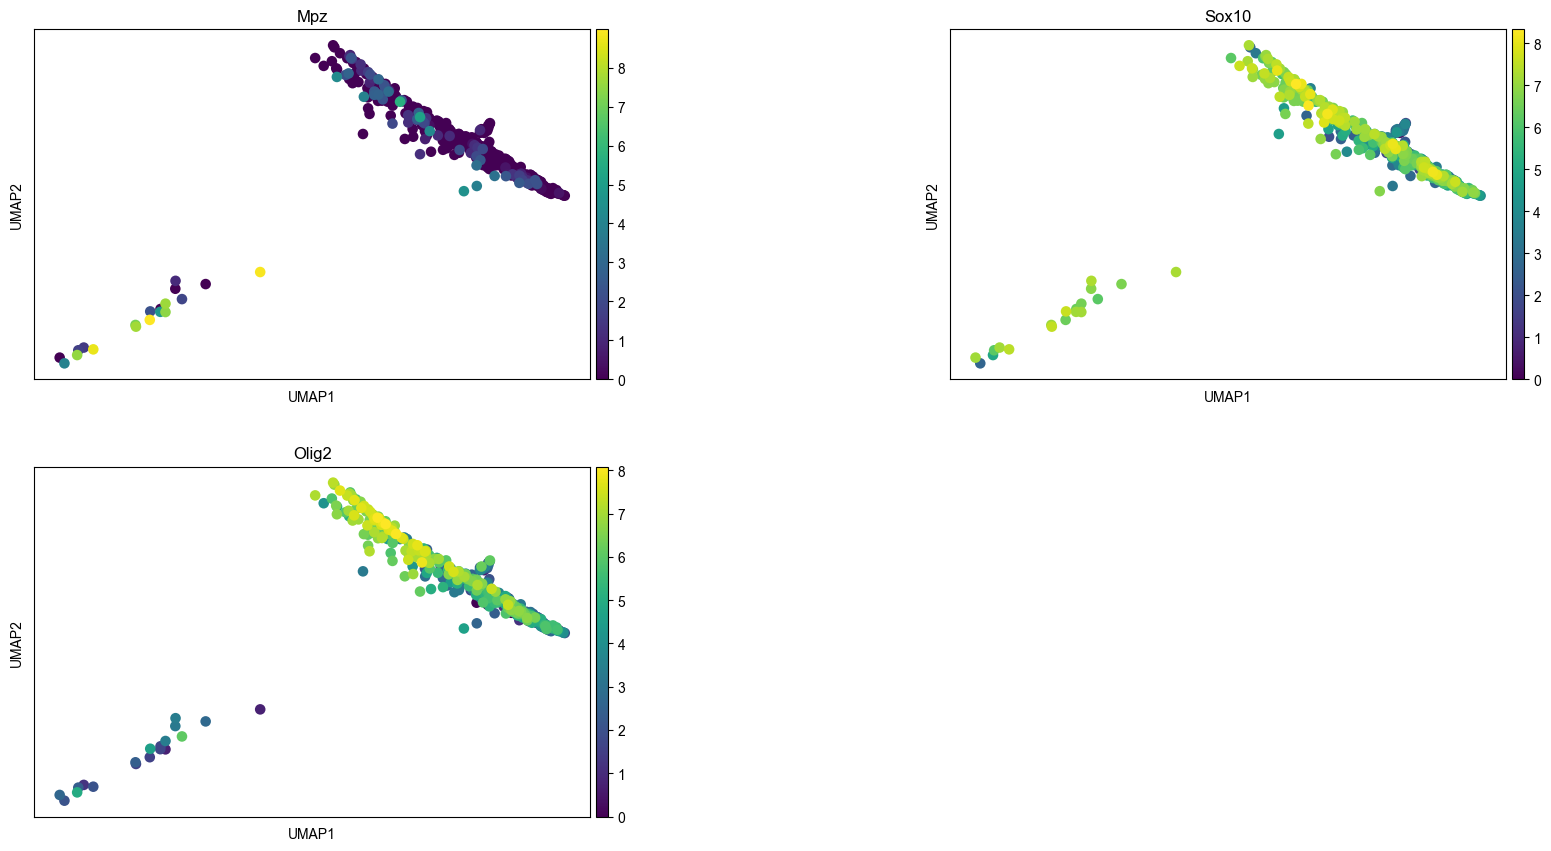

In [51]:
sc.pl.umap(
    adata,
    color=["Mpz",'Sox10','Olig2'],
    wspace=0.5,
    ncols=2,
)

In [71]:
sc.tl.leiden(adata, resolution=0.1, key_added='leiden_0.1',n_iterations=2)

In [52]:
sc.tl.leiden(adata, resolution=0.2, key_added='leiden_0.2',n_iterations=2)

In [53]:
sc.tl.leiden(adata, resolution=0.3, key_added='leiden_0.3',n_iterations=2)

In [54]:
sc.tl.leiden(adata, resolution=0.4, key_added='leiden_0.4',n_iterations=2)

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:737: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  dot_ax.scatter(x, y, **kwds)


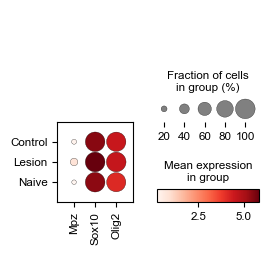

In [56]:
sc.pl.dotplot(adata, ["Mpz",'Sox10','Olig2'], groupby='Condition')

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


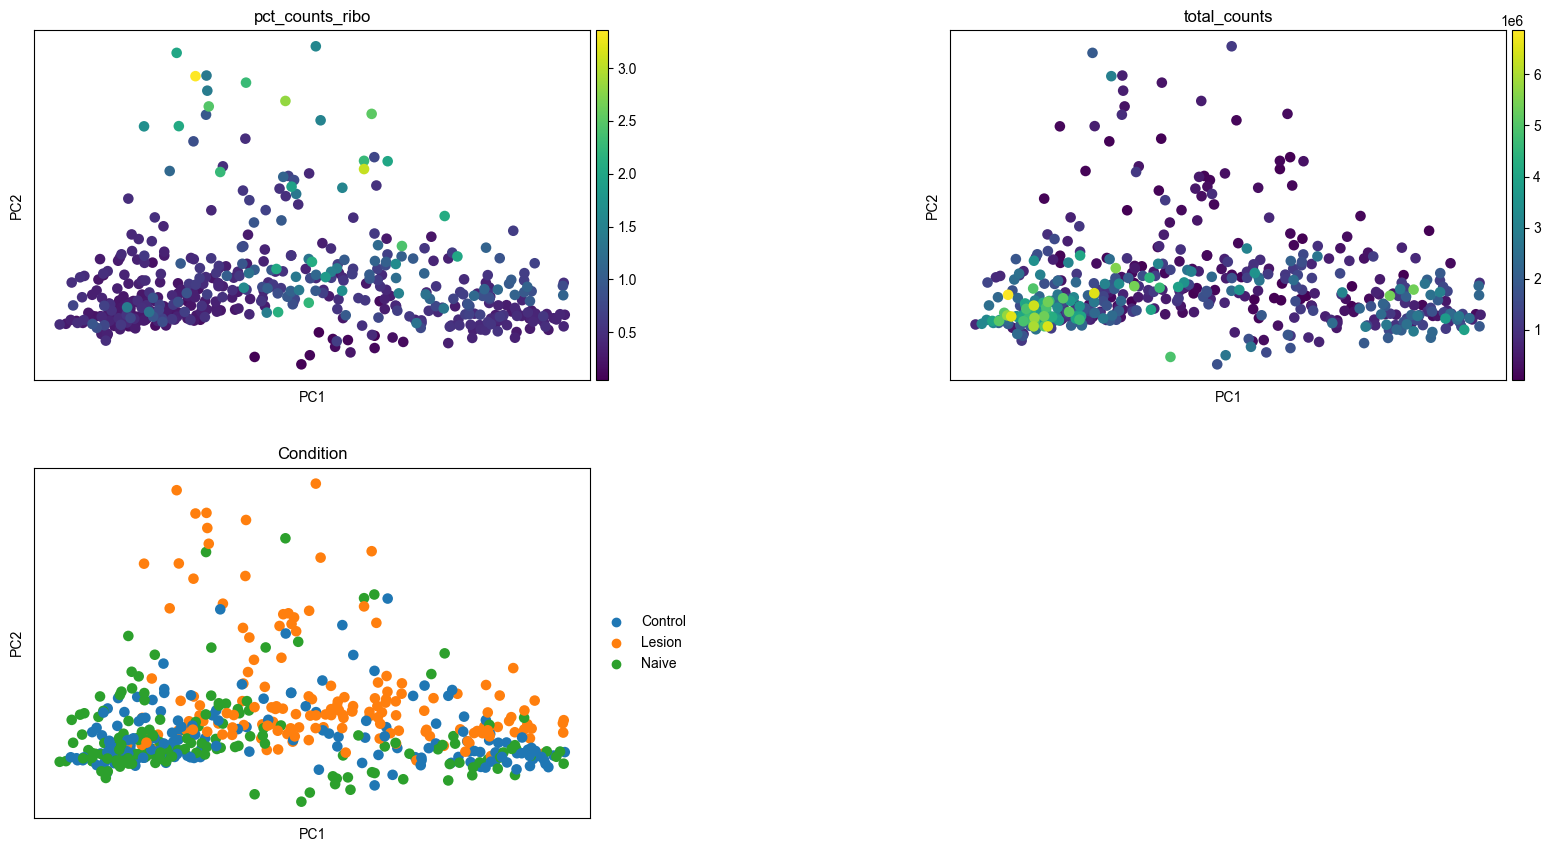

In [64]:
sc.pl.pca(
    adata,
    color=["pct_counts_ribo","total_counts","Condition"],
    wspace=0.5,
    ncols=2,
)

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 

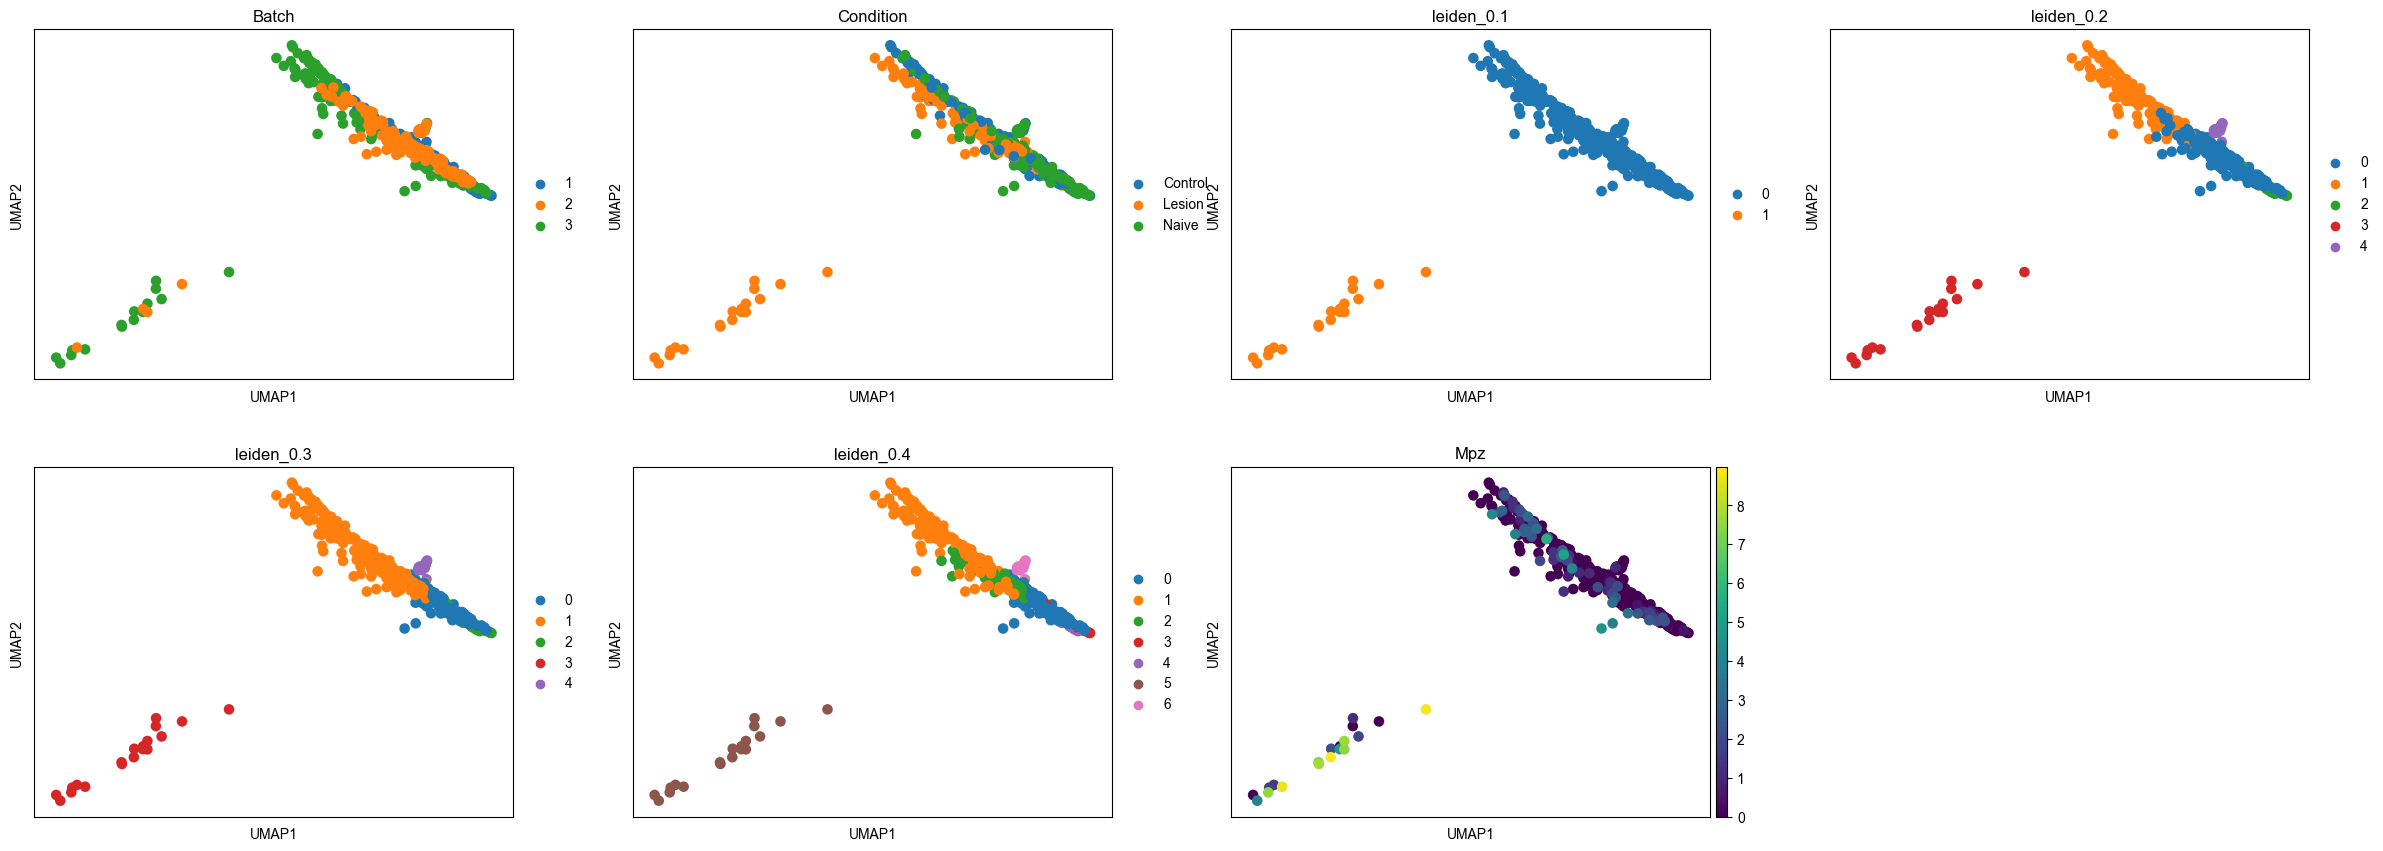

In [72]:
sc.pl.umap(adata, color=["Batch", "Condition","leiden_0.1",'leiden_0.2','leiden_0.3','leiden_0.4','Mpz'])

In [66]:
adata.write_h5ad("dt_out/0_preprocessing/invivo_combined_post_manual_qc_hvg_norm_log1p_leiden.h5ad")

In [67]:
adata

AnnData object with n_obs × n_vars = 517 × 19459
    obs: 'condition', 'sample', 'Sample_id', 'Plate', 'Animal', 'Batch', 'Condition', 'Well', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_ERCC', 'pct_counts_ERCC', 'n_genes', 'outlier_mt', 'outlier_total', 'outlier_ngenes', 'outlier_ERCC', 'leiden', 'leiden_0.5', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4'
    var: 'gene_symbol', 'gene_name', 'type', 'gene_symbol_with_control', 'mt', 'ribo', 'ERCC', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'sample_colors', 'log1p', 'hvg', 'pca', 'Animal_colors', 'Condition_colors', 'Batch_colors', 'neighbors', 'umap', 'leiden', 'l

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 

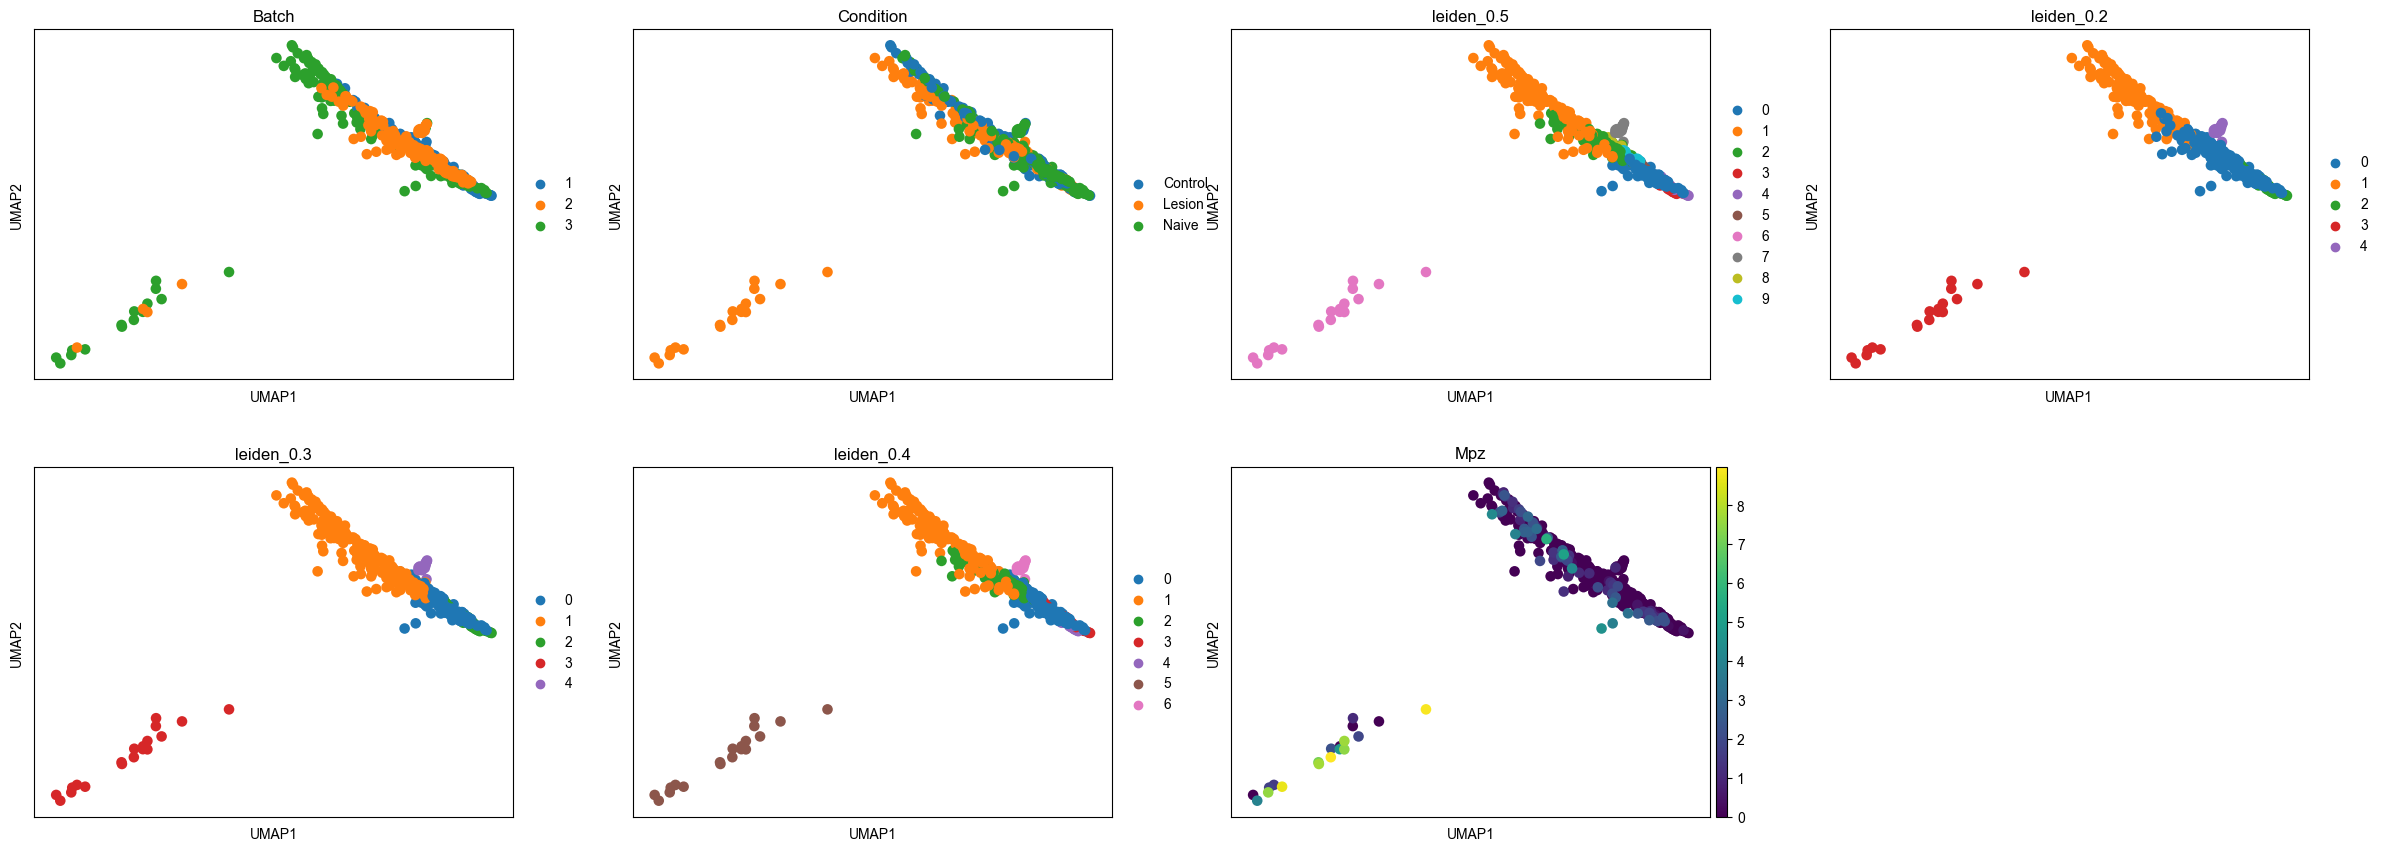

In [70]:
sc.pl.umap(adata, color=["Batch", "Condition","leiden_0.5",'leiden_0.2','leiden_0.3','leiden_0.4','Mpz'])

In [78]:
gene_list_1 = ['Olig2','Sox10','Olig1','Pdgfra','Cspg4','Myrf']
gene_list_2 = ['Olig2','Sox10','Pdgfra','Cspg4','Ascl1','Plp1','Opalin','Myrf','Mbp','Pou3f1','Mpz','Egr2','Prx','Pmp22']
gene_list_3 = ['Pou3f1','Src','Erbb3','Ntrk2','Itga1','Dag1','Ptn']

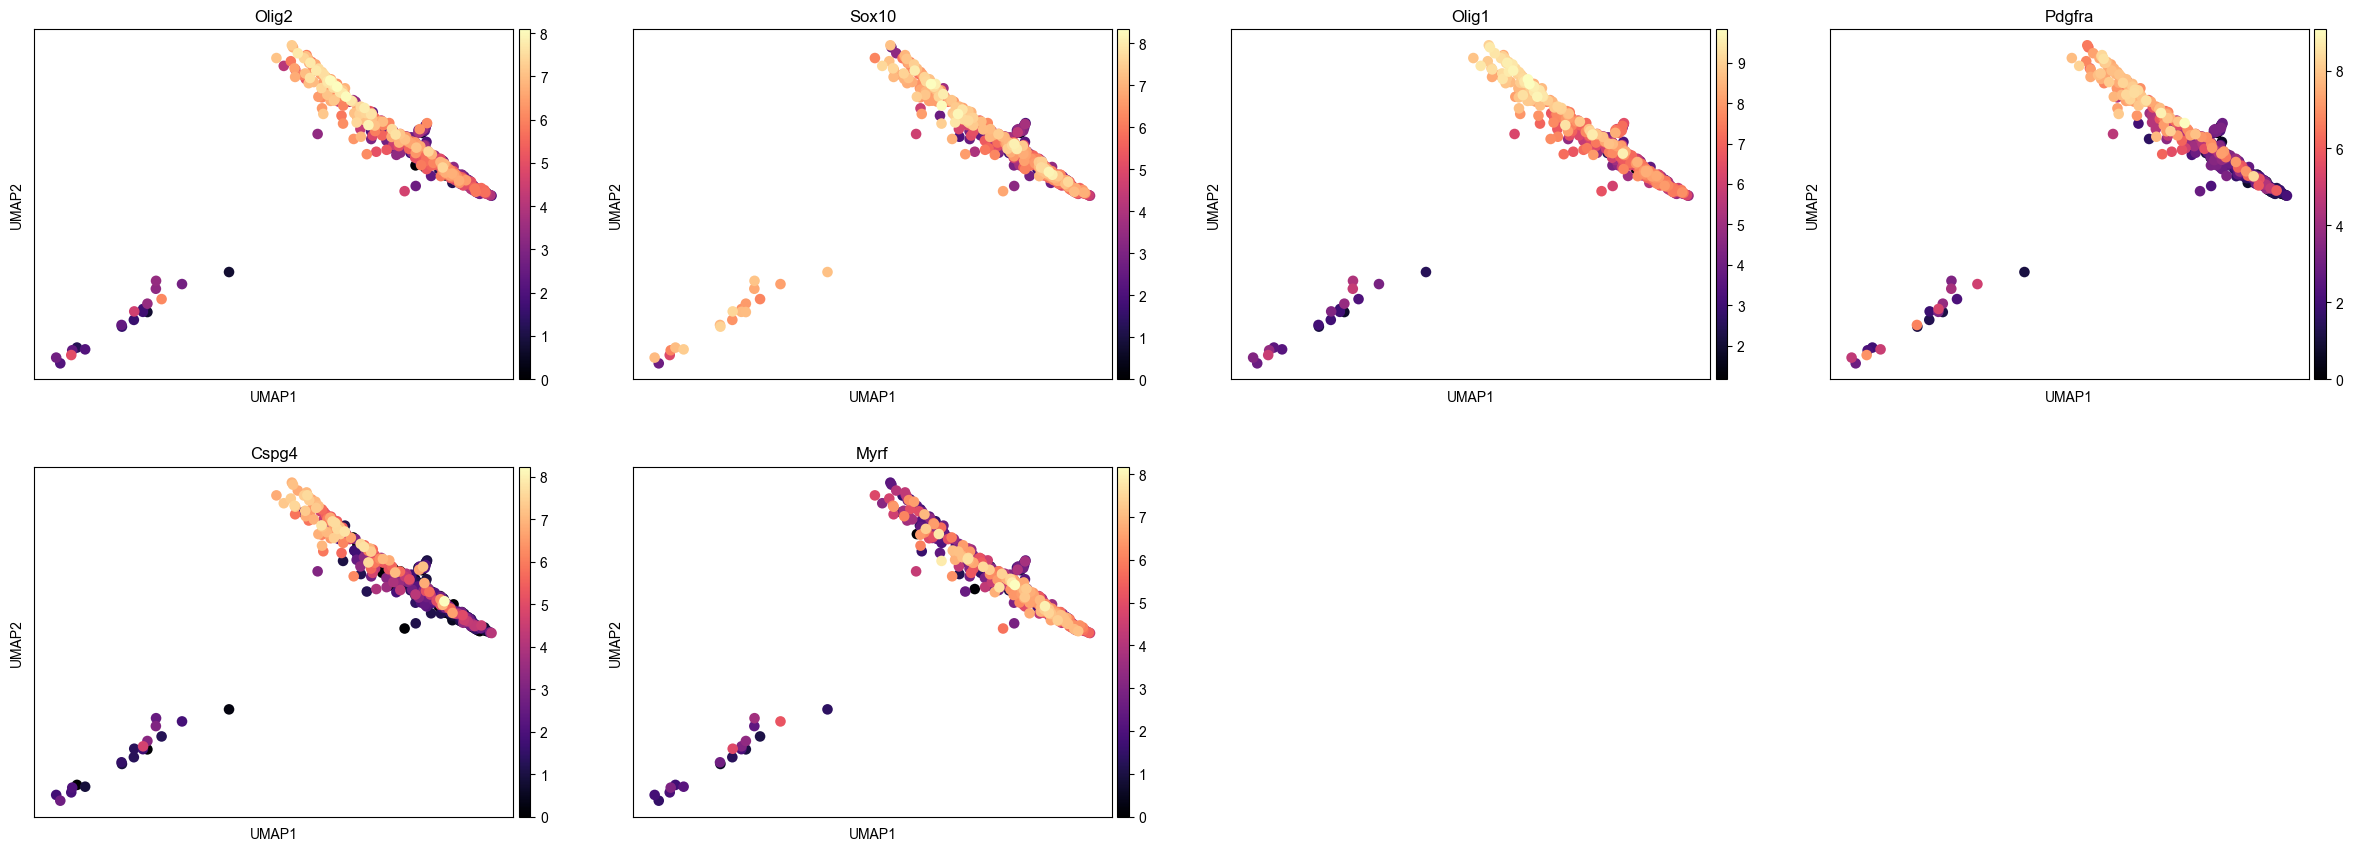

In [74]:
sc.pl.umap(adata, color=gene_list_1,cmap = "magma", save = "umap_markers_invivo_v2.pdf")

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


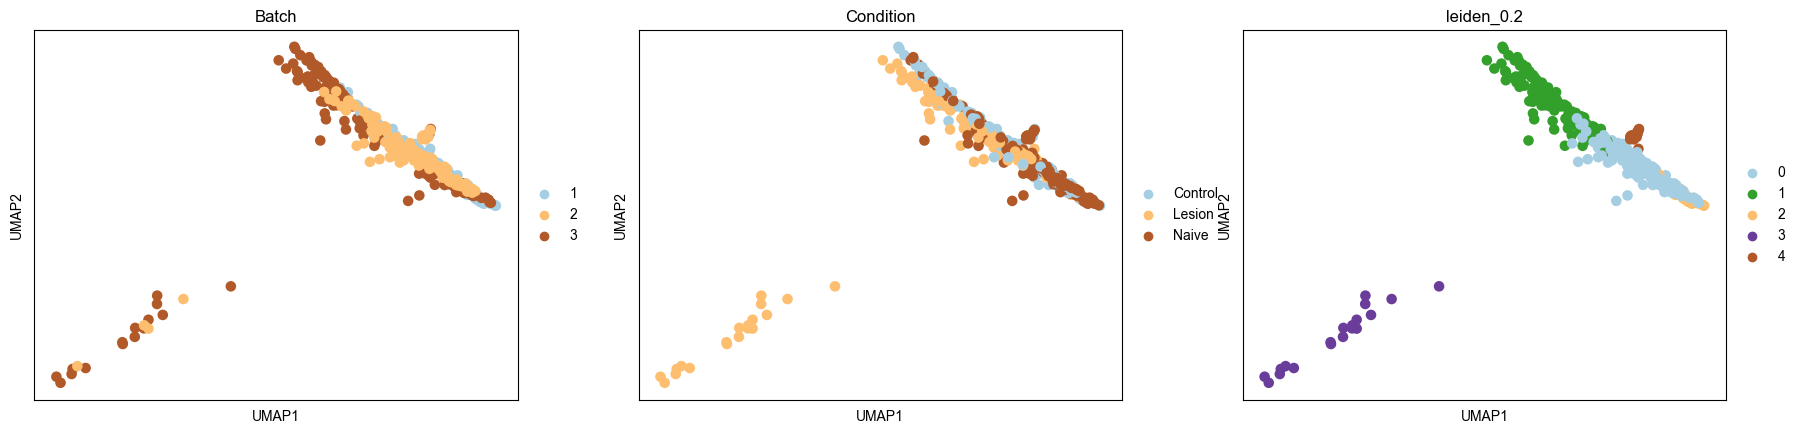

In [75]:
sc.pl.umap(adata, color=["Batch", "Condition",'leiden_0.2'],palette = "Paired", save = "umap_clusters_invivo_v2.pdf")

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:453: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:453: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:453: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  row_ax = sns.violinplot(
/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_stacked_violin.py:453: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated 

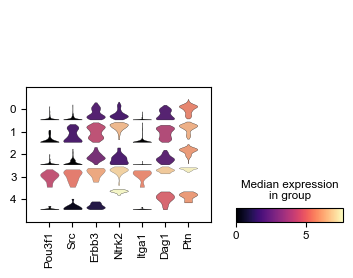

In [79]:
sc.pl.stacked_violin(adata, gene_list_3, groupby='leiden_0.2',cmap = "magma", save = "stacked_violin_markers_invivo_v2.pdf")

/Users/yy8/miniconda/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:737: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  dot_ax.scatter(x, y, **kwds)


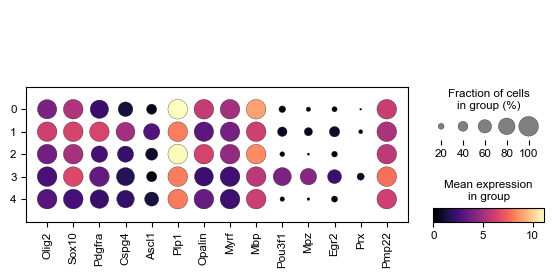

In [81]:
sc.pl.dotplot(adata, gene_list_2, groupby='leiden_0.2',cmap = "magma",save = "dotplot_gene_list2_markers_invivo_v2.pdf")

In [82]:
adata.write_h5ad("dt_out/0_preprocessing/invivo_combined_post_manual_qc_hvg_norm_log1p_leiden_post_figures.h5ad")

In [85]:
adata.uns['log1p']

{'base': None}